### Transpilation

Transpilation is a process where

<ol>
    <li>The gates used in the circuit are mapped to the basis gate set of the hardware</li>
    <li>The circuit is optimized by lowering the number of gates whenever possible</li>
    <li>The virtual qubits from the circuit are mapped to the physical qubits on the hardware to ensure that the number of SWAP gates is minimized</li>
</ol>

In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_error_map

We are selecting a 27 qubit fake backend instead of 127 qubit real device for better visualization

In [2]:
service = QiskitRuntimeService()
backend = service.get_backend('ibm_cairo')

We can find out the basis gate set of each backend by a simple command

In [3]:
backend.configuration().basis_gates

['cx', 'id', 'rz', 'sx', 'x']

In [4]:
backend.properties().gate_error('cx',[1,2])

0.007277427632417899

We can provide any superset of the basis gate set for transpilation. We shall first include a SWAP gate in the superset.

Let us select a random circuit for the visualization.

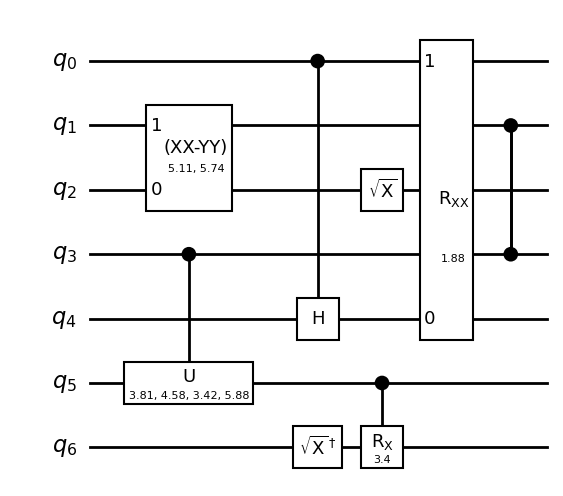

In [5]:
from qiskit.circuit.random import random_circuit

circ = random_circuit(7, depth=2, max_operands=2, seed=0)
circ.draw('mpl', fold=-1, style='bw')

First, we shall use a superset of the basis gate sets by including SWAP in the gate set.

In [7]:
from qiskit import transpile

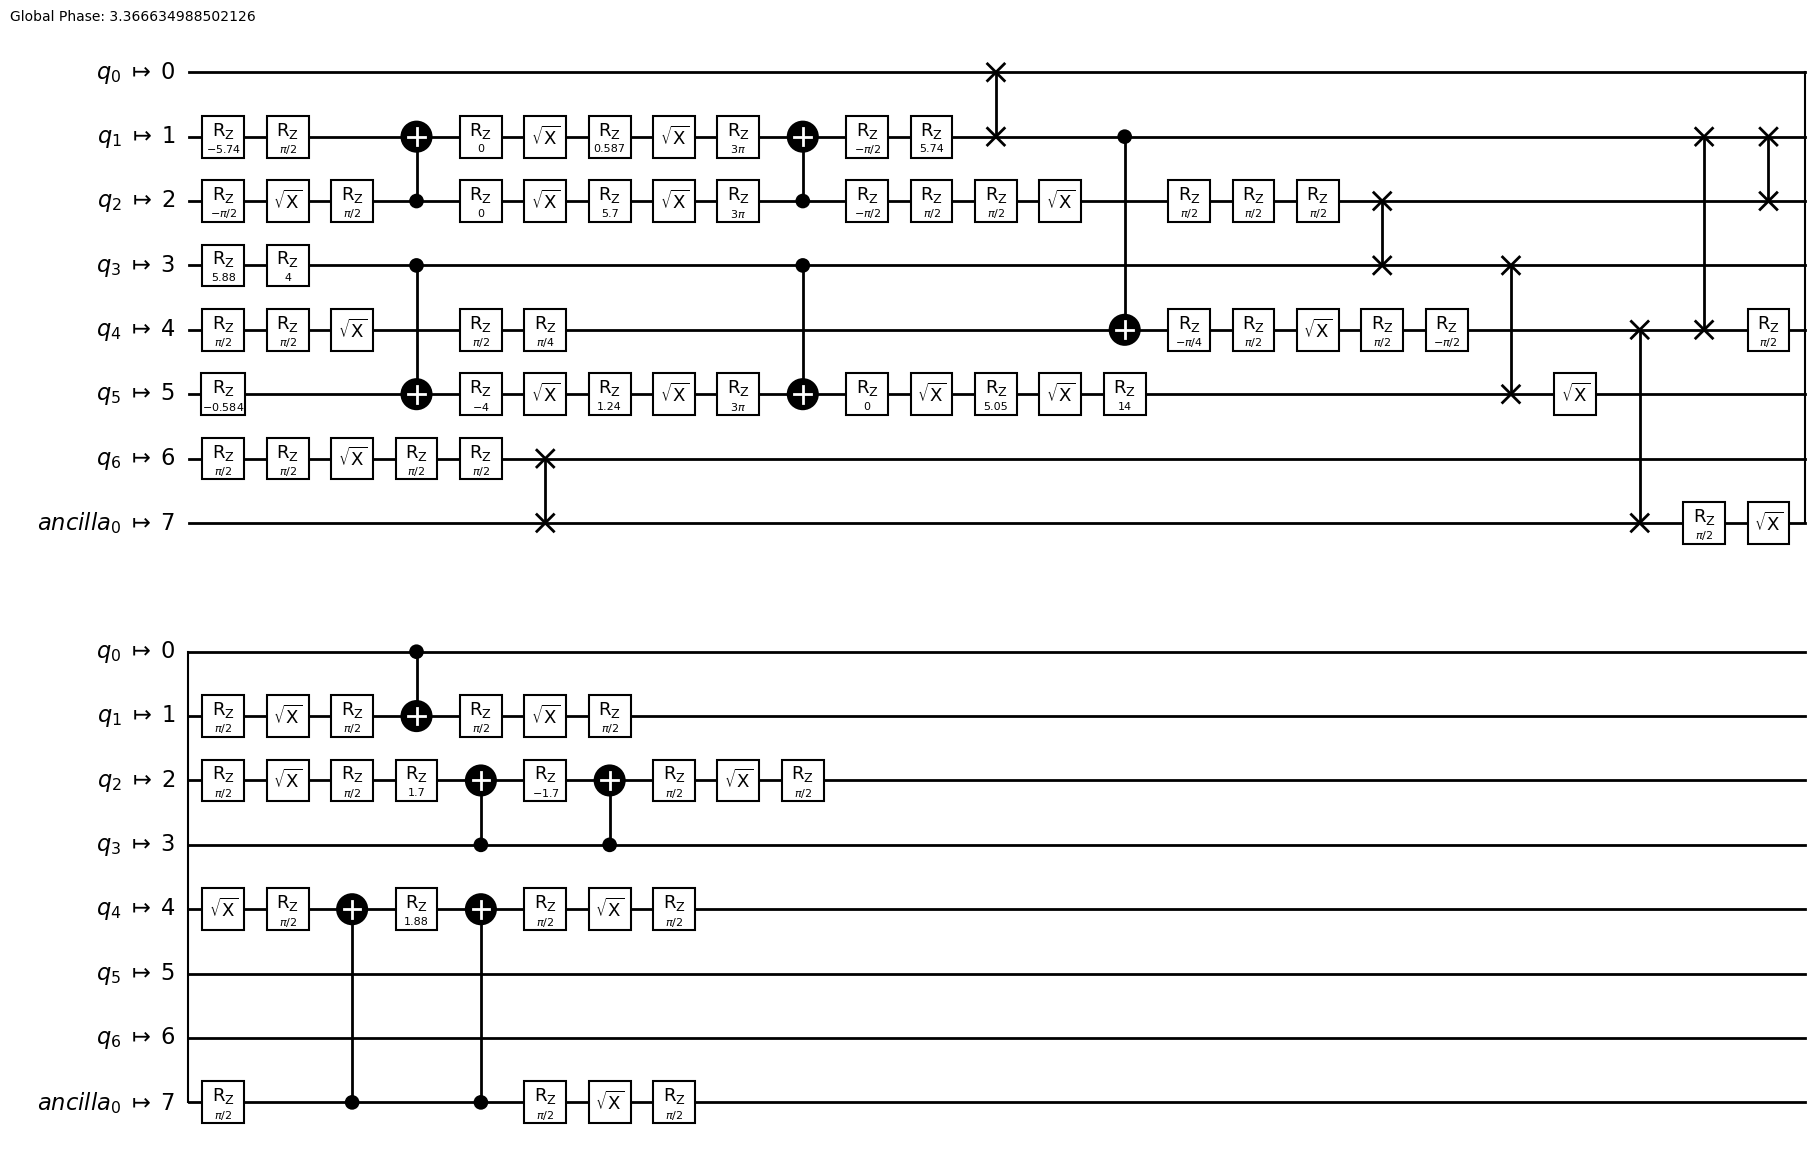

In [8]:
trans_circ = transpile(circ, backend, optimization_level=0, basis_gates=['x','sx','cx','rz','id','swap'])
trans_circ.draw('mpl', style='bw', idle_wires=False)

Each SWAP gate is realized by 3 CNOT gates. We can see this by removing the SWAP gate from the basis gate set

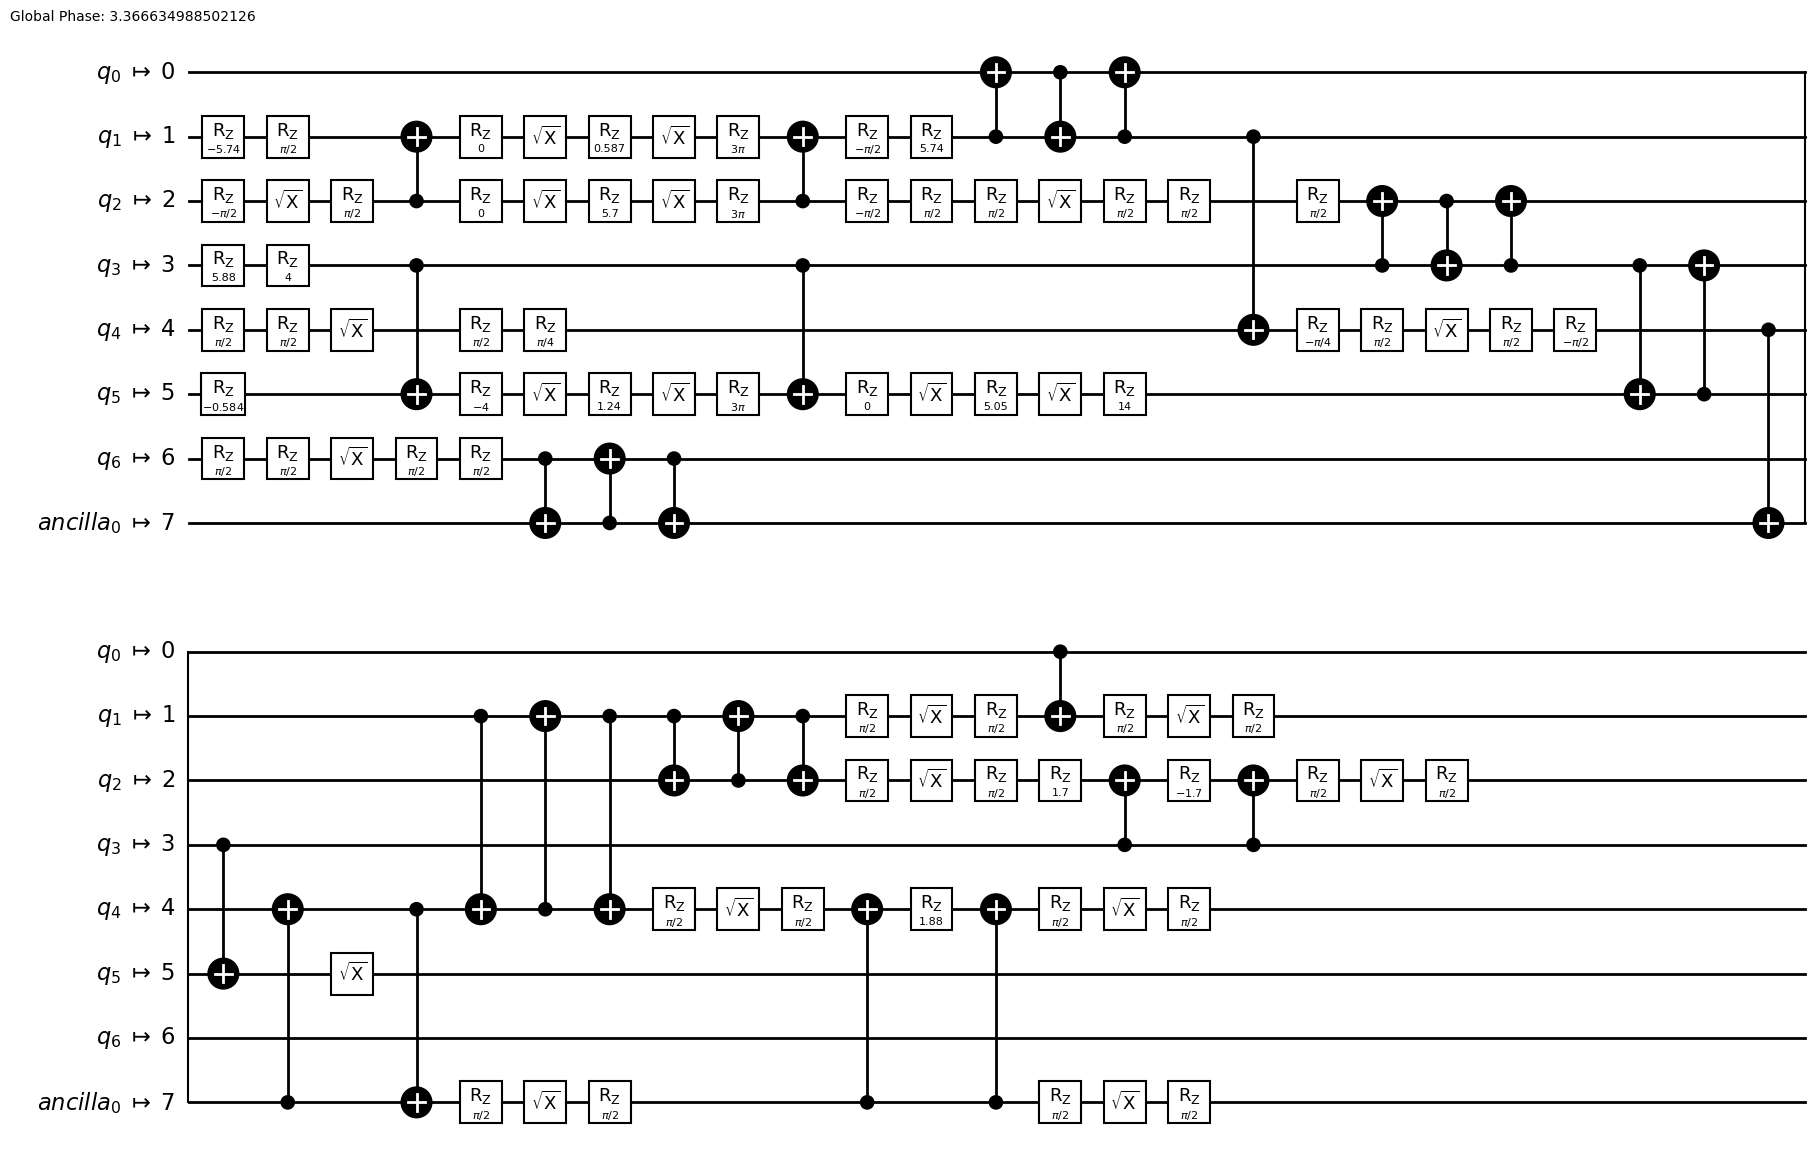

In [9]:
trans_circ = transpile(circ, backend, optimization_level=0, basis_gates=['x','sx','cx','rz','id'])
trans_circ.draw('mpl', style='bw', idle_wires=False)

In [10]:
print(trans_circ.depth())

40


Optimization level 0 simply decomposes the gates in the circuit into basis gates. However, it does not perform any further optimization. It can be noted that in the above circuit, there are some Rz gates with angle 0. These gates are essentially identity and can be removed from the circuit. Moreover, the virtual qubits from the circuit have been placed on the same qubit number on the physical qubits of the hardware. This may not be ideal for SWAP minimization.

Higher optimization levels removes redundant gates and finds better placement of qubits for minimization of SWAP gates.

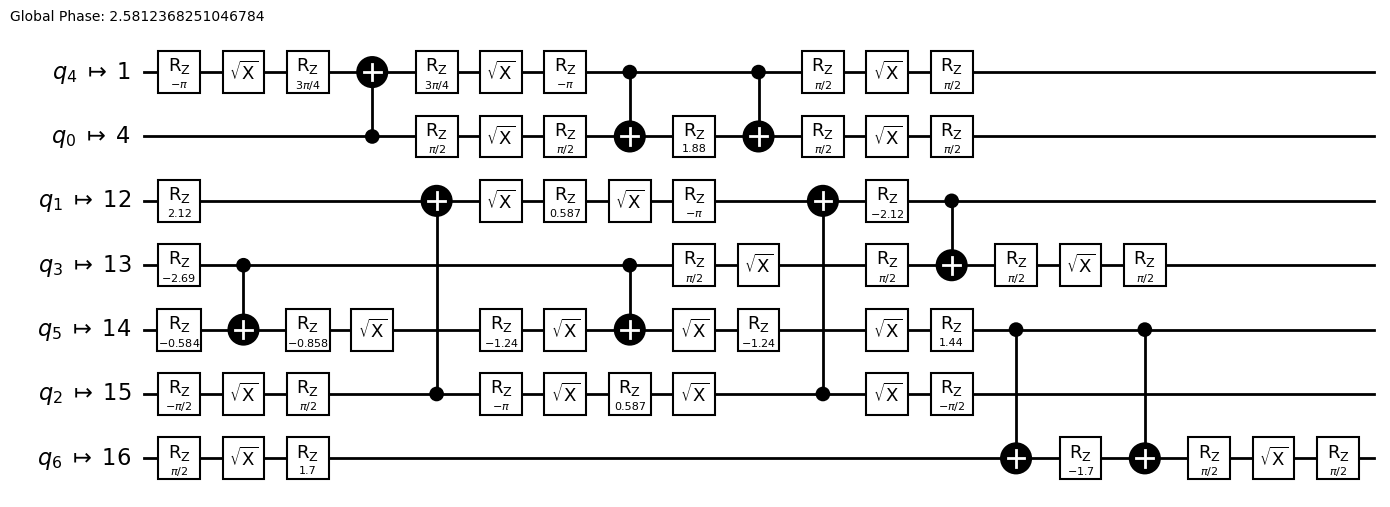

In [13]:
trans_circ = transpile(circ, backend, optimization_level=1, basis_gates=['x','sx','cx','rz','id'])
trans_circ.draw('mpl', style='bw', idle_wires=False)

In [14]:
print(trans_circ.depth())

17


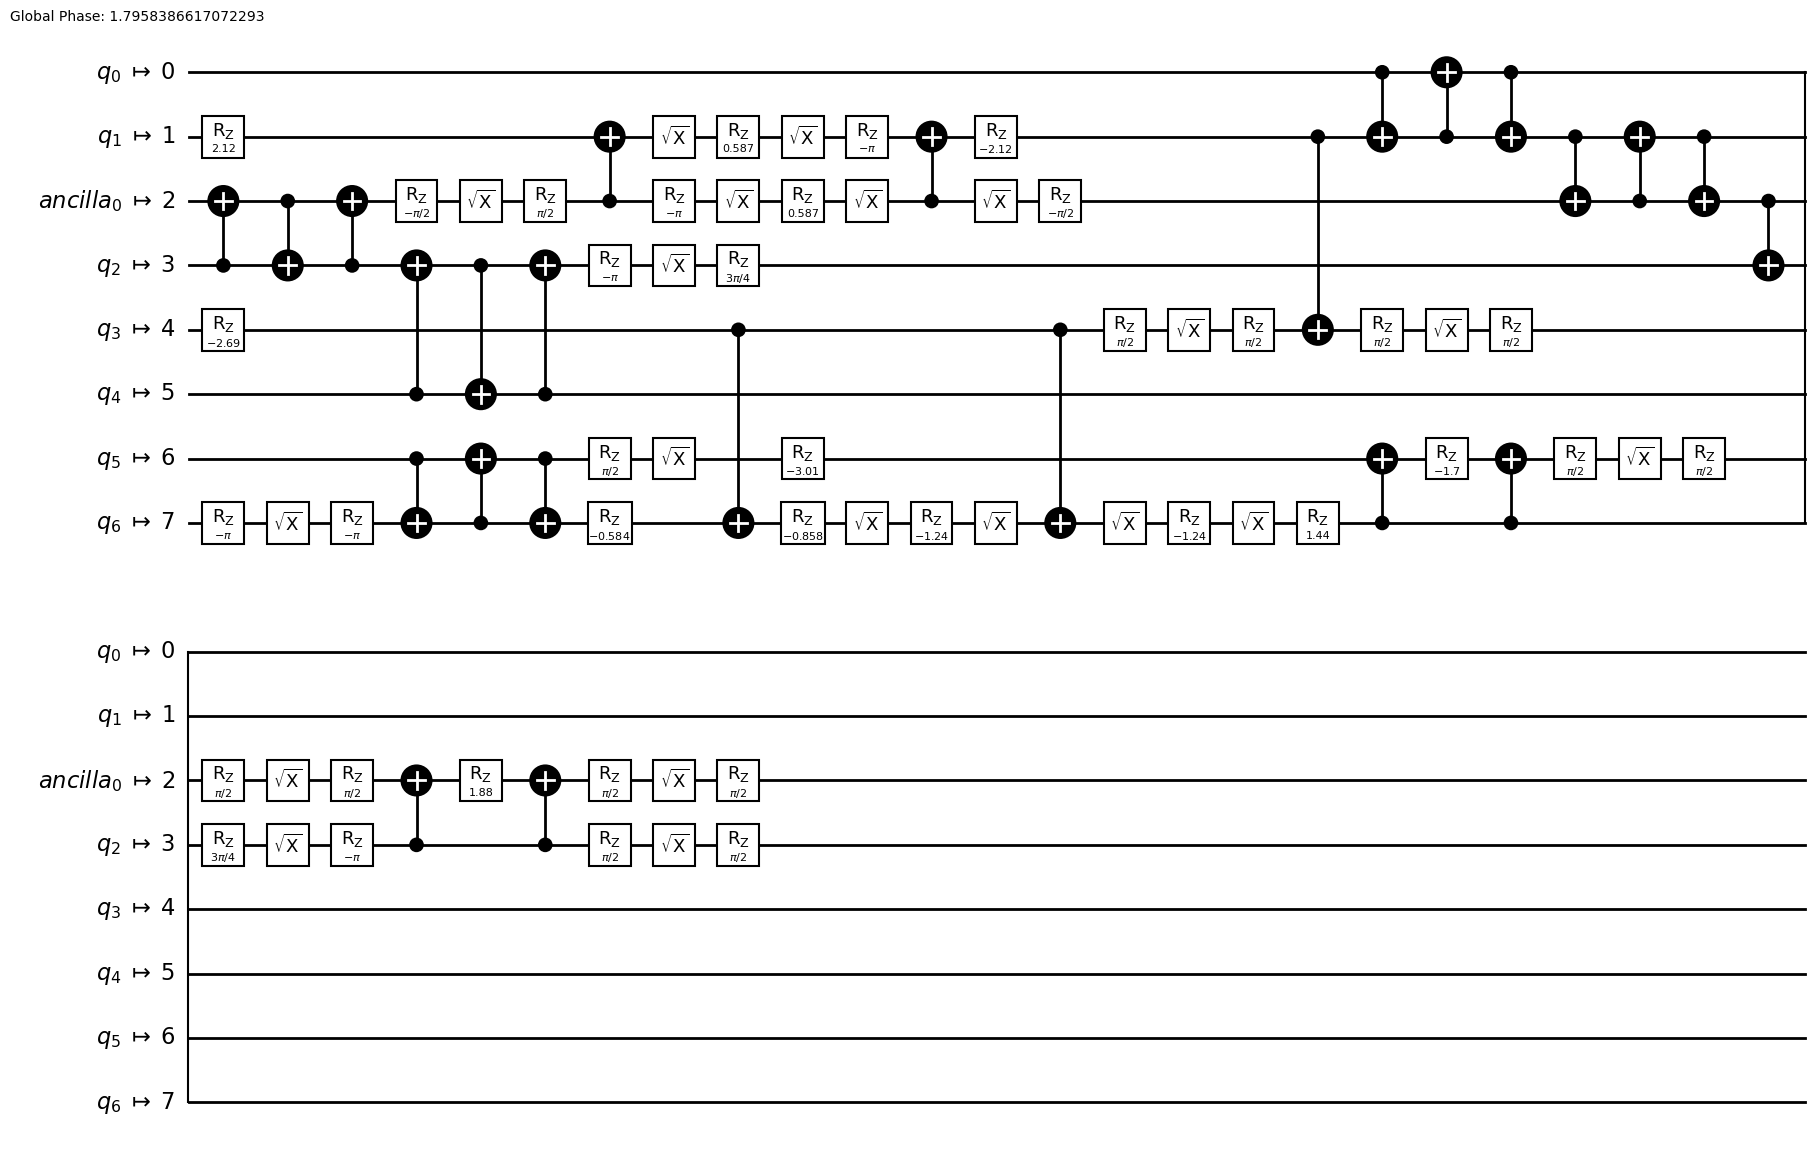

In [15]:
test_circ = transpile(circ, backend, optimization_level=1, basis_gates=['x','sx','cx','rz','id'], initial_layout=[0,1,3,4,5,6,7])
test_circ.draw('mpl', style='bw', idle_wires=False)

Note from the error map that not all qubits and interactions have the same noise strength. Higher optimization levels can be used which will not only minimize the number of SWAP gates, but will also try to select better quality qubits and interactions to suppress the effect of noise.

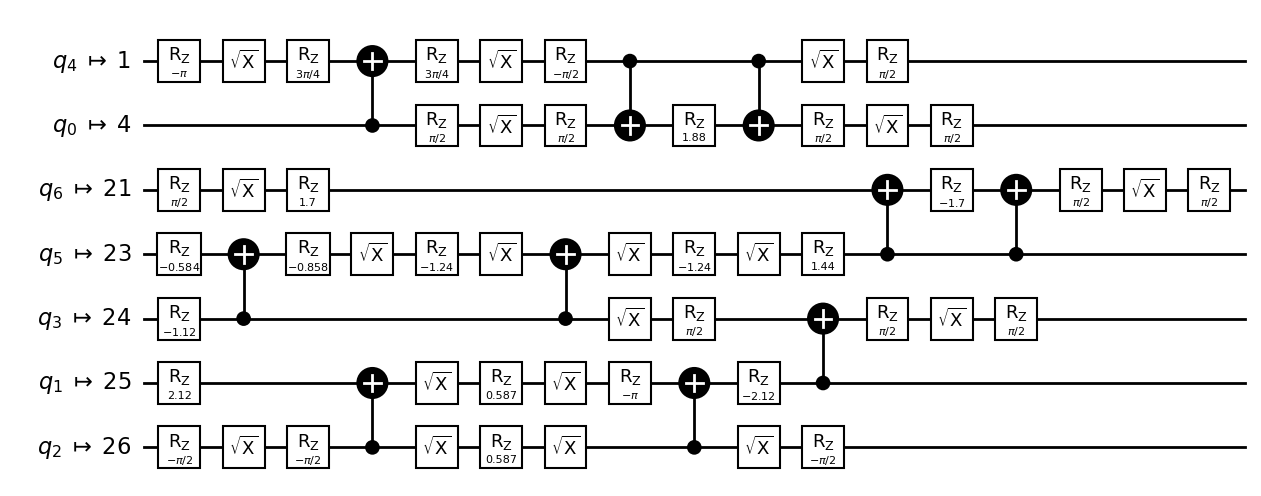

In [16]:
trans_circ = transpile(circ, backend, optimization_level=2, basis_gates=['x','sx','cx','rz','id'])
trans_circ.draw('mpl', style='bw', idle_wires=False)

In [17]:
print(trans_circ.depth())

17


Finally, note that each qubit has a different depth in the circuits. So the measurement will be at different times for each of them. This is usually difficult in current quantum devices. So we can schedule the circuit to place the gates "As late as possible" (ALAP) so that all the measurements are at the same time.

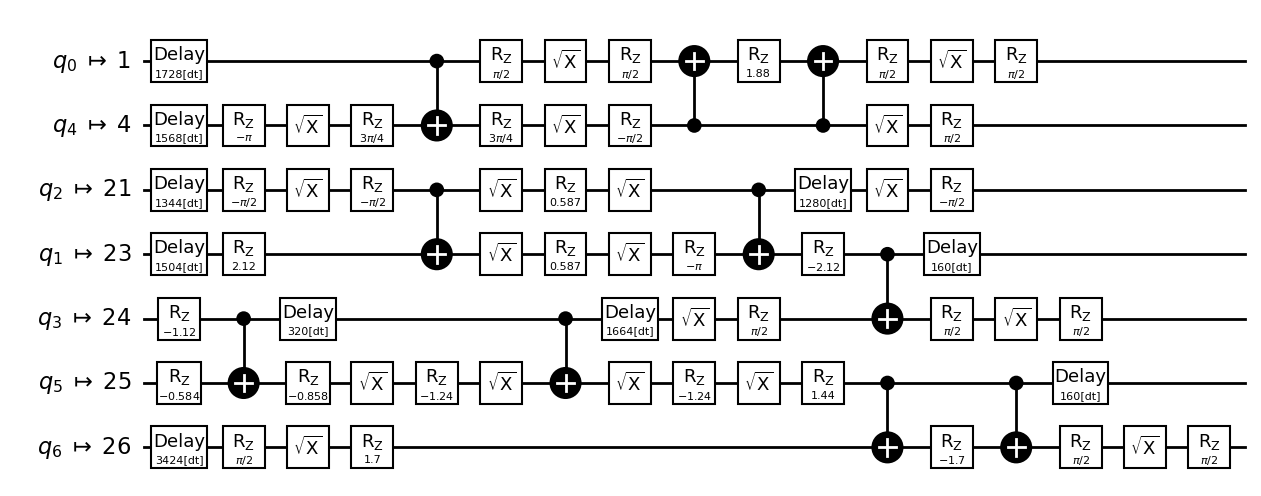

In [18]:
alap_circ = transpile(circ, backend, optimization_level=2, basis_gates=['x','sx','cx','rz','id'], scheduling_method='alap')
alap_circ.draw('mpl', style='bw', idle_wires=False)

### An example of transpiler pass

In [19]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPScheduleAnalysis, PadDynamicalDecoupling
from qiskit.visualization import timeline_drawer

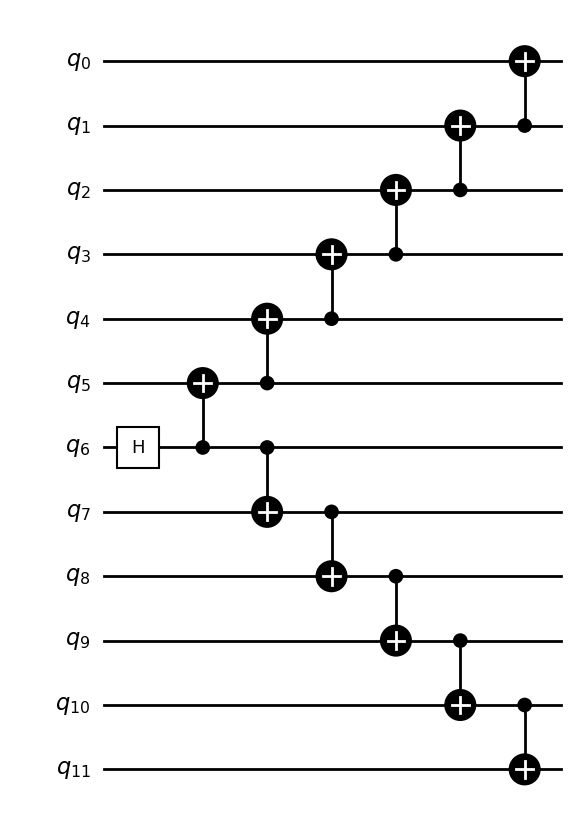

In [20]:
num_qubits = 12
qc = QuantumCircuit(num_qubits)
mid = num_qubits//2
qc.h(mid)
for i in range(mid,0,-1):
    qc.cx(i,i-1)

for i in range(mid,num_qubits-1):
    qc.cx(i,i+1)

qc.draw('mpl',style='bw',fold=-1)

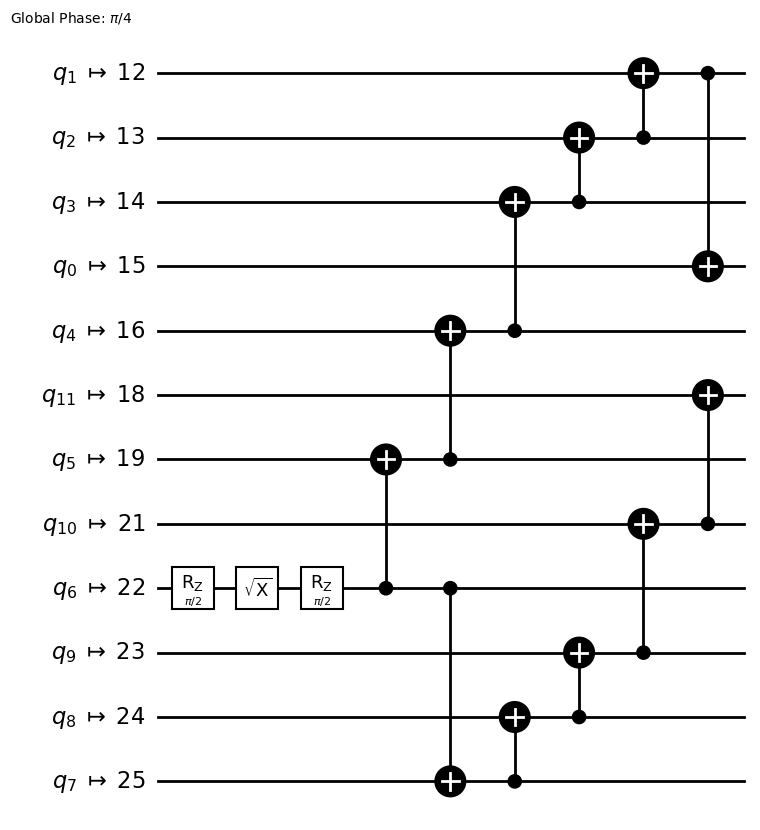

In [21]:
qc = transpile(qc, backend)
qc.draw('mpl',style='bw',fold=-1,idle_wires=False)

In [22]:
durations = InstructionDurations.from_backend(backend)

In [23]:
durations.duration_by_name_qubits

{('id', (0,)): (3.5555555555555554e-08, 's'),
 ('id', (1,)): (3.5555555555555554e-08, 's'),
 ('id', (2,)): (3.5555555555555554e-08, 's'),
 ('id', (3,)): (3.5555555555555554e-08, 's'),
 ('id', (4,)): (3.5555555555555554e-08, 's'),
 ('id', (5,)): (3.5555555555555554e-08, 's'),
 ('id', (6,)): (3.5555555555555554e-08, 's'),
 ('id', (7,)): (3.5555555555555554e-08, 's'),
 ('id', (8,)): (3.5555555555555554e-08, 's'),
 ('id', (9,)): (3.5555555555555554e-08, 's'),
 ('id', (10,)): (3.5555555555555554e-08, 's'),
 ('id', (11,)): (3.5555555555555554e-08, 's'),
 ('id', (12,)): (3.5555555555555554e-08, 's'),
 ('id', (13,)): (3.5555555555555554e-08, 's'),
 ('id', (14,)): (3.5555555555555554e-08, 's'),
 ('id', (15,)): (3.5555555555555554e-08, 's'),
 ('id', (16,)): (3.5555555555555554e-08, 's'),
 ('id', (17,)): (3.5555555555555554e-08, 's'),
 ('id', (18,)): (3.5555555555555554e-08, 's'),
 ('id', (19,)): (3.5555555555555554e-08, 's'),
 ('id', (20,)): (3.5555555555555554e-08, 's'),
 ('id', (21,)): (3.5555

In [24]:
dd_sequence = [XGate(), XGate()]
pm = PassManager([ALAPScheduleAnalysis(durations),PadDynamicalDecoupling(durations, dd_sequence)])

In [25]:
qc_dd = pm.run(qc)

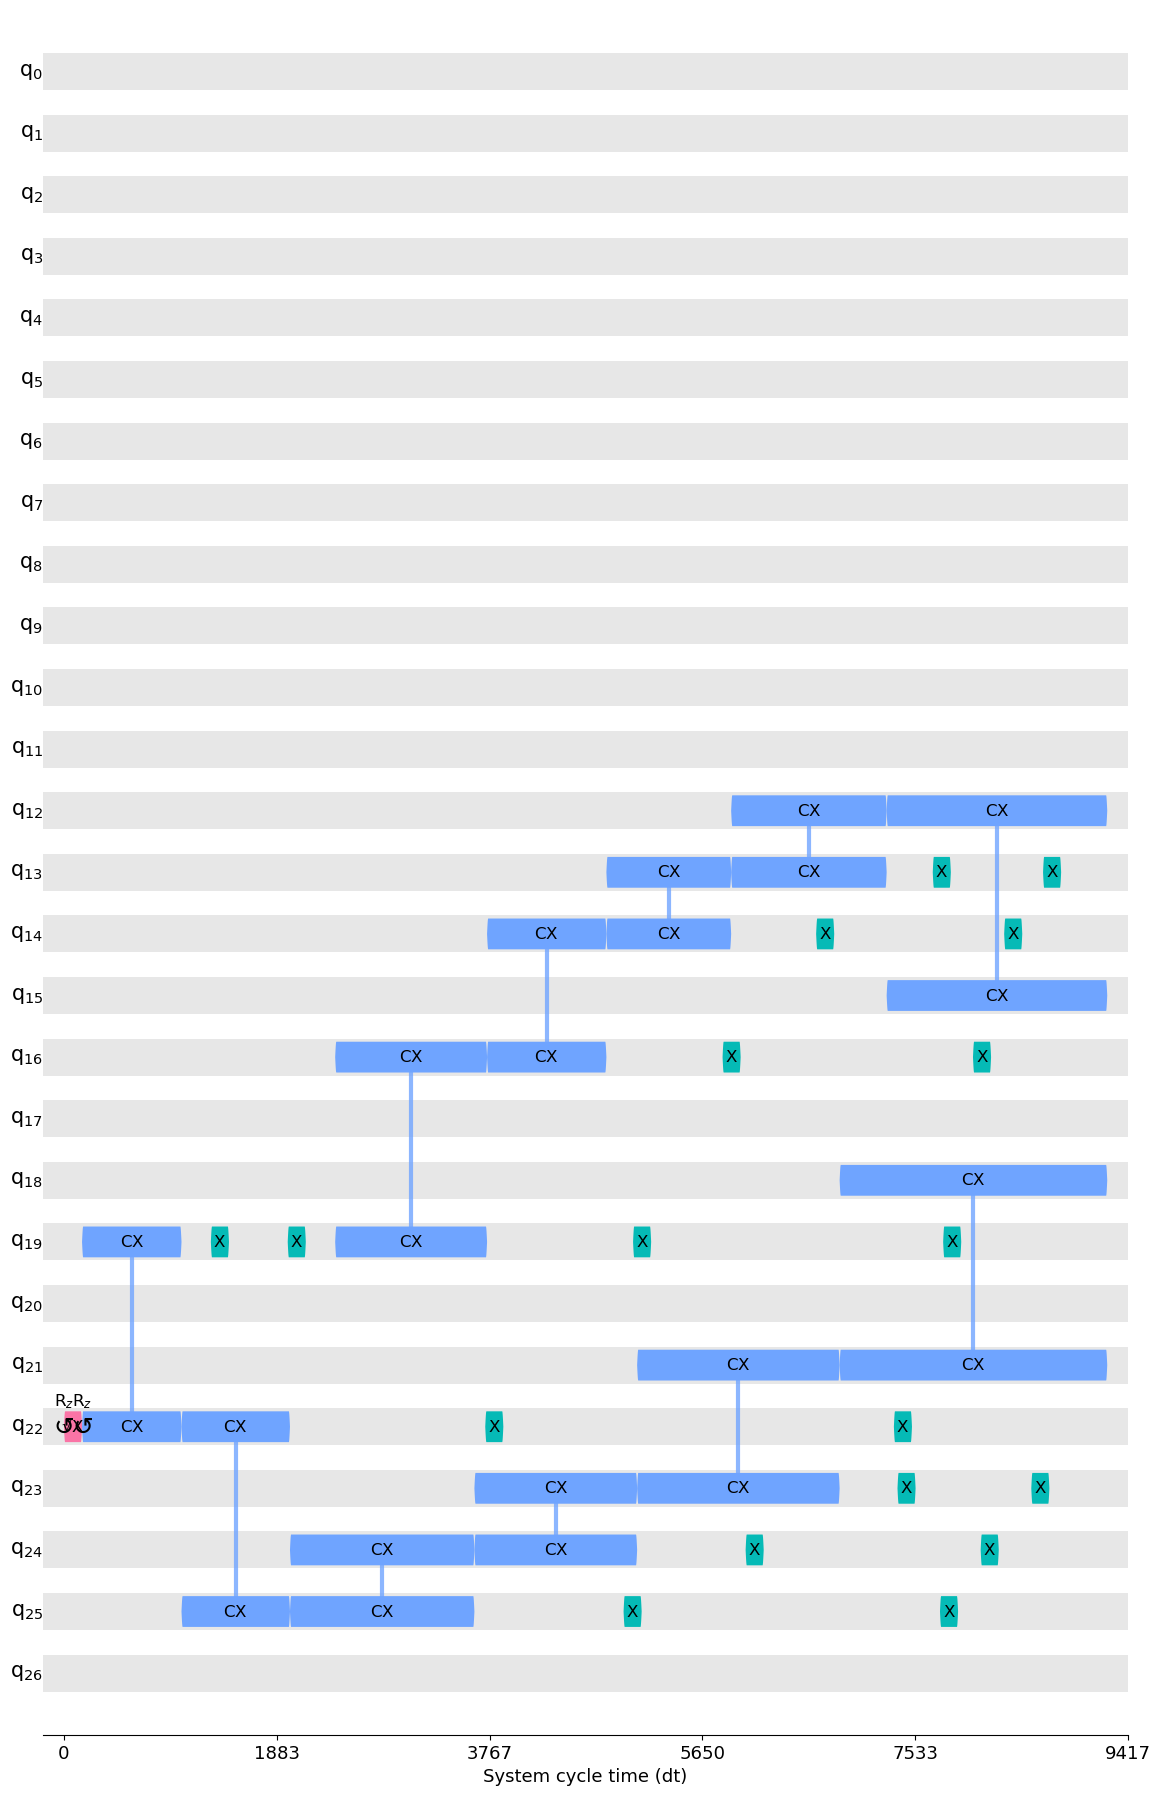

In [26]:
timeline_drawer(qc_dd)